In [1]:
!pip install torch

In [2]:
import sys

In [3]:
 !pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.1 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import torchvision.models as models
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
import torch.nn.functional as F
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch version 2.1.0+cu118
Torchvision version 0.16.0+cu118
Numpy version 1.23.5
Pandas version 1.5.3


## Setup Datasets

In [5]:
class DiseaseClassificationDataset():
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

## Model

In [6]:
class DiseaseClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super(DiseaseClassifier, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


In [7]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataloaders

- Batching our dataset
- It's faster to train the model in batches instead of one at a time.

In [17]:
transform = transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_folder = './train_validate_test/train/'
valid_folder = './train_validate_test/validation/'
test_folder = './train_validate_test/test/'

train_dataset = DiseaseClassificationDataset(train_folder, transform=transform)
val_dataset = DiseaseClassificationDataset(valid_folder, transform=transform)
test_dataset = DiseaseClassificationDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Simple Training Loop

In [12]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = DiseaseClassifier(num_classes=6)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validate loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/22 [00:00<?, ?it/s]

Validate loop:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 2.0676939133404812, Validation loss: 352.45306880463585


Training loop:   0%|          | 0/22 [00:00<?, ?it/s]

Validate loop:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 1.503098232343237, Validation loss: 4.095491880887406


Training loop:   0%|          | 0/22 [00:00<?, ?it/s]

Validate loop:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 1.2511253728427063, Validation loss: 1.4236327604050154


Training loop:   0%|          | 0/22 [00:00<?, ?it/s]

Validate loop:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 1.1524866099940134, Validation loss: 1.3440037259446367


Training loop:   0%|          | 0/22 [00:00<?, ?it/s]

Validate loop:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 1.1149452439868373, Validation loss: 1.186635634710085


# Visualize Losses




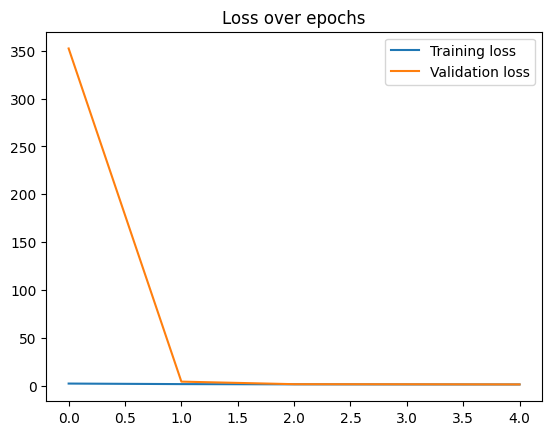

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [14]:
# model.to('cpu')

DiseaseClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kerne

In [15]:
torch.save(model.state_dict(), "/content/drive/MyDrive/input/trained_efficientnet1.pth")

# **Testing cell**

In [20]:
from sklearn.metrics import accuracy_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = '/content/drive/MyDrive/input/trained_efficientnet1.pth' # your saved model
model = DiseaseClassifier(num_classes=6).to(device)
model.load_state_dict(torch.load(PATH))

# Testing
model.eval()
all_test_preds = []
all_test_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(all_test_labels, all_test_preds)
print(f"Test Accuracy: {test_accuracy}")


Test Accuracy: 0.5242290748898678
